# Datawhale 零基础入门数据挖掘-Task4 建模调参

## 建模调参主要目标
了解常用模型和模型的评价和调参策略

In [2]:
from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, validation_curve, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, make_scorer
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor
from collections import Counter
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import datetime
from bayes_opt import BayesianOptimization
# pd.options.display.max_columns = None
warnings.filterwarnings('ignore')
from notebook.services.config import ConfigManager
cm = ConfigManager().update('notebook', {'limit_output': 10})

In [3]:
def reduce_mem_usage(df):
    '''iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    '''
    start_mem = df.memory_usage().sum()/1024/1024
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum()/1024/1024
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
sample_feature = pd.read_csv('data_for_tree.csv')
sample_feature = reduce_mem_usage(sample_feature)

Memory usage of dataframe is 133.63 MB
Memory usage after optimization is: 42.90 MB
Decreased by 67.9%


In [5]:
continuous_feature_names = [x for x in sample_feature.columns 
                            if x not in ['price', 'brand', 'model', 'bodyType',
                                         'fuelType', 'city', 'gearbox']]

In [6]:
sample_feature = sample_feature.dropna().replace('-', 0).reset_index(drop=True)
sample_feature['notRepairedDamage'] = sample_feature['notRepairedDamage'].astype(np.float32)
train = sample_feature[continuous_feature_names + ['price']]
train_x = train[continuous_feature_names]
train_y = train['price']

In [7]:
train_x.shape

(51225, 81)

In [7]:
lr = LinearRegression(normalize=True)
lr.fit(train_x, train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

**查看线性回归模型的截距与权重**

In [8]:
'intercept: ' + str(lr.intercept_)
sorted(dict(zip(continuous_feature_names, lr.coef_)).items(), key=lambda x:x[1], reverse=True)

[('SaleID',
  array([ 7.11157879e-05,  1.34910322e-03,  8.02903696e+00, -2.41519432e+02,
          7.86681067e+13, -1.37517414e+03, -2.06960583e+04,  6.49306136e+04,
         -3.58428819e+04,  6.99026904e+03,  7.98916443e+04, -4.41563745e+05,
          4.73790672e+03, -2.71289053e+05, -3.63624503e+03, -2.54954617e+04,
         -9.15919188e+03, -5.57981191e+04, -8.56746966e+03,  2.25768187e+02,
          1.30296370e+12, -1.51062697e-02,  1.16067397e+02, -2.48369016e+12,
          1.20517037e+00,  2.71076164e-02,  8.14256327e-02,  5.51951116e-02,
         -6.41213596e-04,  3.03356548e-02,  7.11546671e-01,  2.02032742e-02,
          1.23671002e-03,  7.78225994e-02,  9.35669078e-04, -1.02591177e-05,
          2.23157371e-01, -4.23879343e-02, -4.50745248e-03, -1.24066567e-04,
          7.91085066e-02, -4.90898433e-01,  7.04682262e-06, -5.93318641e-02,
          5.05290953e-02, -6.63271967e-01,  2.04555430e-01,  8.89235325e+00,
          1.20968585e+02,  1.53615597e-04,  8.73659180e+00, -1.2

In [9]:
subsample_index = np.random.randint(low=0, high=len(train_y), size=50)

In [10]:
subsample_index

array([30746, 50981, 19916, 25718, 20018,  7311, 51075, 29152, 37888,
        4184, 42290, 40318,  5654, 24151, 46468, 37988, 22400,  3502,
       23015,  7225, 21342, 40592, 24396, 34229, 11517, 19206, 31463,
       15214, 11244,  5670, 34545,  7558, 40601, 51041,  6356, 25990,
        9475, 39035, 42632, 27597,  1204,  7346, 14650, 25013, 38313,
       47619, 28501, 10055, 30783, 31283])

看看特征v_9与标签的散点图

The predicted price is obvious different from true price


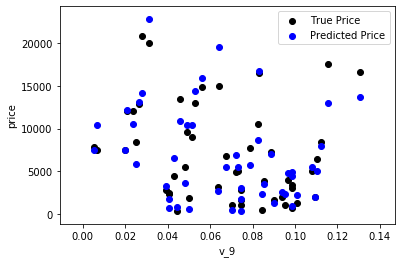

In [11]:
plt.scatter(train_x['v_9'][subsample_index], train_y['price'][subsample_index], color='black')
plt.scatter(train_x['v_9'][subsample_index], lr.predict(train_x.loc[subsample_index]), color='blue')
plt.xlabel('v_9')
plt.ylabel('price')
plt.legend(['True Price', 'Predicted Price'], loc='upper right')
print('The predicted price is obvious different from true price')
plt.show()

In [12]:
mean_absolute_error(train_y, lr.predict(train_x))

1315.471644704734

发现模型的预测结果（蓝色点）与真实标签（黑色点）的分布差异较大，且部分预测值出现了小于0的情况，说明我们的模型存在一些问题

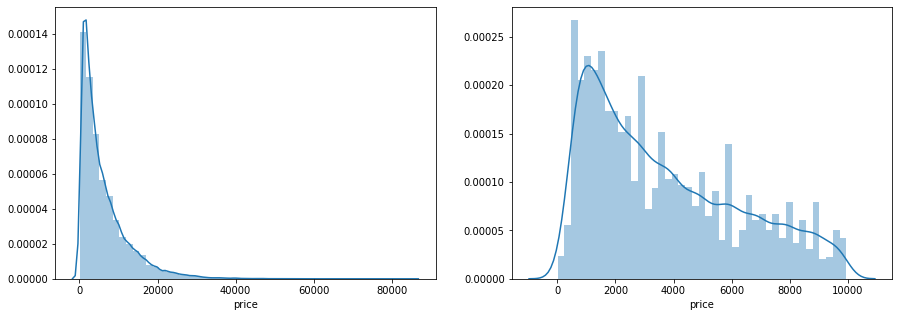

In [15]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.distplot(train_y)
plt.subplot(1, 2, 2)
sns.distplot(train_y[train_y<np.quantile(train_y, 0.8)])
plt.show()

通过作图我们发现数据的标签（price）呈现长尾分布，不利于我们的建模预测。原因是很多模型都假设数据误差项符合正态分布，而长尾分布的数据违背了这一假设

In [8]:
# 对数据进行log变换，使标签贴近于正太分布
train_y_ln = np.log(train_y + 1)

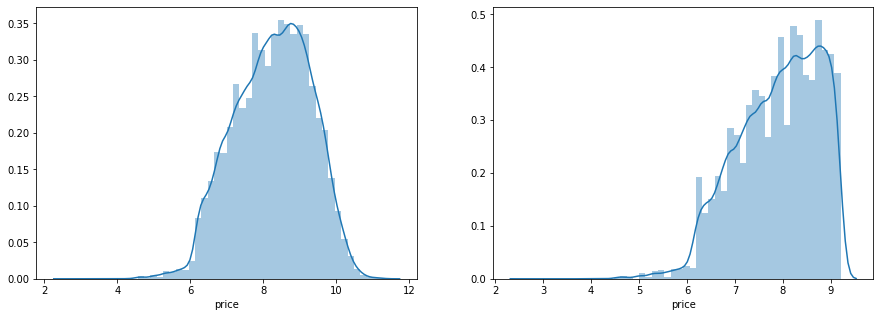

In [32]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.distplot(train_y_ln)
plt.subplot(1, 2, 2)
sns.distplot(train_y_ln[train_y_ln<np.quantile(train_y_ln, 0.8)])
plt.show()

The predicted price seems normal after np.log transforming


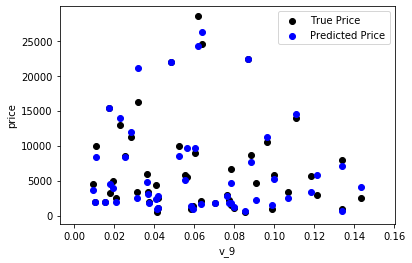

In [35]:
# 利用处理过的price进行模型训练，并观察预测效果
lr.fit(train_x, train_y_ln)
plt.scatter(train_x['v_9'][subsample_index], train_y[subsample_index], color='black')
plt.scatter(train_x['v_9'][subsample_index], np.exp(lr.predict(train_x.loc[subsample_index])), color='blue')
plt.xlabel('v_9')
plt.ylabel('price')
plt.legend(['True Price','Predicted Price'],loc='upper right')
print('The predicted price seems normal after np.log transforming')
plt.show()

In [39]:
mean_absolute_error(train_y, np.exp(lr.predict(train_x)))

1298.6974416095977

## 交叉验证

In [44]:
def log_transfer(func):
    def wrapper(y, yhat):
        result = func(np.log(y), np.nan_to_num(np.log(yhat)))
        return result
    return wrapper

In [51]:
scores = cross_val_score(lr, X=train_x, y=train_y_ln, verbose=1, cv=5, 
                         scoring=make_scorer(log_transfer(mean_absolute_error)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.2s finished


In [52]:
print('avg: ', np.mean(scores))

avg:  0.09450160313882443


In [54]:
scores = pd.DataFrame(scores.reshape(1, -1))
scores.columns = ['cv' + str(x) for x in range(1, 6)]
scores.index = ['MAE']
scores

,cv1,cv2,cv3,cv4,cv5
MAE,0.079879,0.254499,0.035344,0.033664,0.069122


In [56]:
sample_feature = sample_feature.reset_index(drop=True)
sample_feature.shape

(51225, 88)

In [57]:
split_point = len(sample_feature) // 5 * 4
train = sample_feature[:split_point].dropna()
val = sample_feature.loc[split_point:].dropna()
train_x = train[continuous_feature_names]
train_y_ln = np.log(train['price'] + 1)
val_x = val[continuous_feature_names]
val_y_ln = np.log(val['price'] + 1)

In [58]:
lr.fit(train_x, train_y_ln)
mean_absolute_error(val_y_ln, lr.predict(val_x))

0.5536478220574627

In [60]:
def plot_learning_curve(estimator, title, x, y, ylim=None, cv=None, n_jobs=1,
                       train_size=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training example')
    plt.ylabel('score')
    train_sizes, train_scores, test_scores = learning_curve(estimator, x, y, 
                                                            cv=cv, n_jobs=n_jobs, train_sizes=train_size,
                                                           scoring=make_scorer(mean_absolute_error))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean-train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color='g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='cross-validation score')
    plt.legend(loc='best')
    return plt

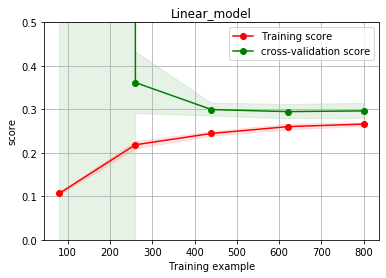

In [62]:
plot_learning_curve(LinearRegression(), 'Linear_model', 
                    train_x[:1000], train_y_ln[:1000], ylim=(0.0, 0.5),cv=5, n_jobs=1)
plt.show()

**多种模型进行对比**

In [65]:
train = sample_feature[continuous_feature_names + ['price']].dropna()
train_x = train[continuous_feature_names]
train_y = train['price']
train_y_ln = np.log(train_y + 1)
models = [LinearRegression(), Ridge(), Lasso()]


In [66]:
result = dict()
for model in models:
    model_name = str(model).split('(')[0]
    scores = cross_val_score(model, X=train_x, y=train_y_ln, verbose=0, cv=5, scoring=make_scorer(mean_absolute_error))
    result[model_name] = scores
    print(model_name + 'is finished')

LinearRegressionis finished
Ridgeis finished
Lassois finished


In [69]:
result = pd.DataFrame(result)
result.index = ['cv' + str(x) for x in range(1,6)]
result

,LinearRegression,Ridge,Lasso
cv1,0.262817,0.263150,0.301962
cv2,0.264567,0.264928,0.303811
cv3,0.263436,0.263615,0.302304
cv4,0.262669,0.262689,0.300799
cv5,0.265555,0.265669,0.303123


### 比较下线性回归模型和L2正则化，L1正则化的参数

intercept-212.99084341766152


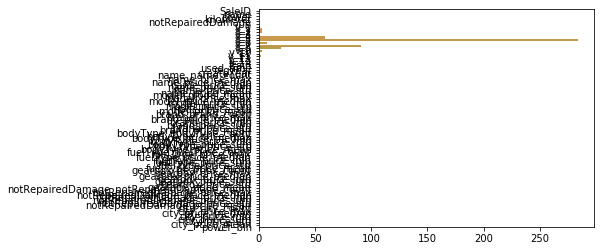

In [70]:
model = LinearRegression().fit(train_x, train_y_ln)
print('intercept' + str(model.intercept_))
sns.barplot(abs(model.coef_), continuous_feature_names)

intercept23.924532988713125


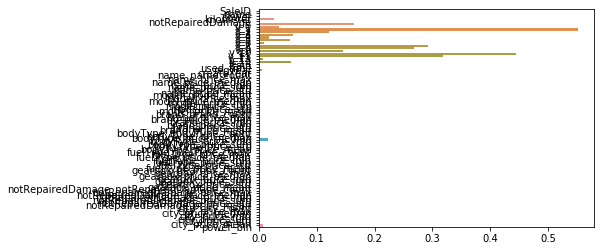

In [71]:
model = Ridge().fit(train_x, train_y_ln)
print('intercept' + str(model.intercept_))
sns.barplot(abs(model.coef_), continuous_feature_names)

intercept7.970650873733202


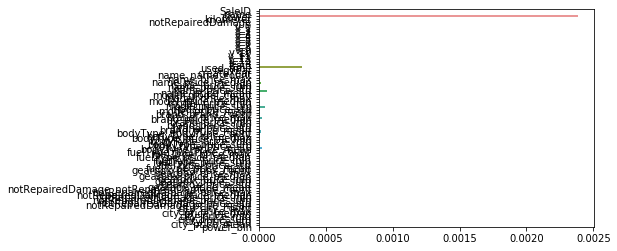

In [72]:
model = Lasso().fit(train_x, train_y_ln)
print('intercept' + str(model.intercept_))
sns.barplot(abs(model.coef_), continuous_feature_names)

**可以发现：**
1. L2正则化在拟合过程中通常都倾向于让权值尽可能小，最后构造一个所有参数都比较小的模型。因为一般认为参数值小的模型比较简单，能适应不同的数据集，也在一定程度上避免了过拟合现象。可以设想一下对于一个线性回归方程，若参数很大，那么只要数据偏移一点点，就会对结果造成很大的影响；但如果参数足够小，数据偏移得多一点也不会对结果造成什么影响，专业一点的说法是『抗扰动能力强』
2. L1正则化有助于生成一个稀疏权值矩阵，进而可以用于特征选择

## 其他模型之间的比较

In [21]:
models = [LinearRegression(),
         DecisionTreeRegressor(),
         RandomForestRegressor(),
         GradientBoostingRegressor(),
         MLPRegressor(solver='lbfgs', max_iter=100),
         XGBRegressor(n_estimators=100),
         LGBMRegressor(n_estimators=100)]

In [27]:
print('ff');

ff


In [24]:
result = dict()
for model in models:
    model_name = str(model).split('(')[0]
    scores = cross_val_score(model, X=train_x, y=pd.DataFrame(train_y_ln), cv=5, scoring=make_scorer(mean_absolute_error))
    result[model_name] = scores
    print(model_name + ' is finished')

LinearRegression is finished
DecisionTreeRegressor is finished
RandomForestRegressor is finished
GradientBoostingRegressor is finished
MLPRegressor is finished
XGBRegressor is finished
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<clas

In [80]:
result = pd.DataFrame(result)
result.index = ['cv' + str(x) for x in range(1, 6)]
result

,LinearRegression,DecisionTreeRegressor,RandomForestRegressor,GradientBoostingRegressor,MLPRegressor,XGBRegressor,LGBMRegressor
cv1,0.262817,0.311375,0.229927,0.230792,216286.799253,0.230681,0.212672
cv2,0.264567,0.301388,0.229511,0.234609,202182.565333,0.234070,0.214051
cv3,0.263436,0.295631,0.230268,0.233843,197204.181071,0.233733,0.213575
cv4,0.262669,0.297272,0.228007,0.229644,243802.203680,0.229183,0.210832
cv5,0.265555,0.311208,0.232113,0.233078,142723.087687,0.233675,0.212930


## 模型调参
主要有3种：
1. 贪心算法 https://www.jianshu.com/p/ab89df9759c8
2. 网格调参 https://blog.csdn.net/weixin_43172660/article/details/83032029
3. 贝叶斯调参 https://blog.csdn.net/linxid/article/details/81189154

In [43]:
# LGB参数集合
objective = ['regression', 'regression_l1', 'mape', 'huber', 'fair']
num_leaves = [3,5,10,15,20,40, 55]
max_depth = [3,5,10,15,20,40, 55]

In [82]:
# 贪心算法：
best_obj = dict()
for obj in objective:
    model = LGBMRegressor(objective=obj)
    score = np.mean(cross_val_score(model, X=train_x, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))
    best_obj[obj] = score
    
best_leaves = dict()
for leaves in num_leaves:
    model = LGBMRegressor(objective=min(best_obj.items(), key=lambda x:x[1])[0], num_leaves=leaves)
    score = np.mean(cross_val_score(model, X=train_x, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))
    best_leaves[leaves] = score
    
best_depth = dict()
for depth in max_depth:
    model = LGBMRegressor(objective=min(best_obj.items(), key=lambda x:x[1])[0],
                          num_leaves=min(best_leaves.items(), key=lambda x:x[1])[0],
                          max_depth=depth)
    score = np.mean(cross_val_score(model, X=train_x, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))
    best_depth[depth] = score

<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'li

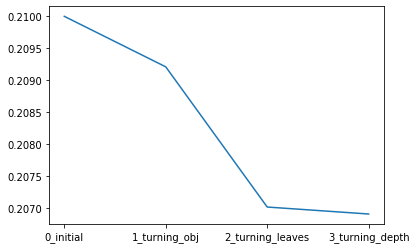

In [84]:
sns.lineplot(x=['0_initial','1_turning_obj','2_turning_leaves','3_turning_depth'], y=[0.21 ,min(best_obj.values()), min(best_leaves.values()), min(best_depth.values())])

### 网格搜索

In [ ]:
parameters = {'objective':objective, 'num_leaves':num_leaves, 'max_depth':max_depth}
model = LGBMRegressor()
clf = GridSearchCV(model, parameters, cv=5)
clf = clf.fit(train_x, train_y)

<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'li

In [47]:
clf.best_params_

{'max_depth': 10, 'num_leaves': 40, 'objective': 'regression'}

In [49]:
model = LGBMRegressor(objective='regression',
                          num_leaves=55,
                          max_depth=15)
np.mean(cross_val_score(model, X=train_x, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))

<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'li

0.2096003002446865

In [9]:
def rf_cv(num_leaves, max_depth, subsample, min_child_samples):
    val = cross_val_score(
        LGBMRegressor(objective = 'regression_l1',
            num_leaves=int(num_leaves),
            max_depth=int(max_depth),
            subsample = subsample,
            min_child_samples = int(min_child_samples)
        ),
        X=train_x, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)
    ).mean()
    return 1 - val

In [10]:
rf_bo = BayesianOptimization(
    rf_cv,
    {
    'num_leaves': (2, 100),
    'max_depth': (2, 100),
    'subsample': (0.1, 1),
    'min_child_samples' : (2, 100)
    }
)

In [11]:
rf_bo.maximize()

|   iter    |  target   | max_depth | min_ch... | num_le... | subsample |
-------------------------------------------------------------------------
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list

In [12]:
1 - rf_bo.max['target']

0.20503131448478595